In [1]:
import sys
import warnings
from dataclasses import dataclass
from typing import Any
#from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib
matplotlib.rc('font', family='Noto Sans CJK JP')
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
warnings.simplefilter("ignore")

In [3]:
from sklearn.model_selection import train_test_split

def generate_simulation_data(N, beta, mu, sigma):
    """

    :param N:インスタンスの長さ
    :param beta: 各特徴量の傾き
    :param mu: 各特徴量は多変量正規分布から生成される。その平均
    :param sigma: 各特徴量は多変量正規分布から生成される。その分散共分散行列
    :return: train test split data,(X_train, X_test, y_train, y_test)
    """
    X = np.random.multivariate_normal(mu, sigma, N)
    epsilon = np.random.normal(0, 0.1, N)

    y = X @ beta + epsilon

    return train_test_split(X, y, test_size=0.2, random_state=42)

N = 1000
J = 3
mu = np.zeros(J)
sigma = np.array([[1,0,0], [0,1,0], [0,0,1]])
beta = np.array([0,1,2])
X_train ,X_test, y_train, y_test = generate_simulation_data(N, beta, mu, sigma)

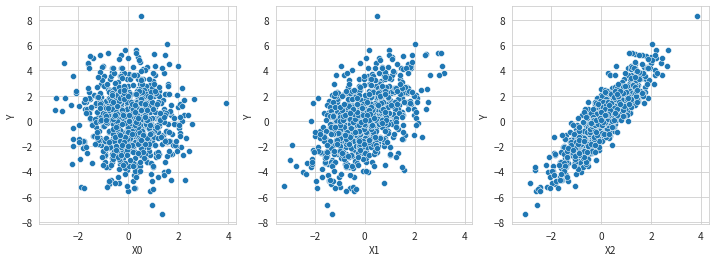

In [4]:
def plot_scatter(X, y, var_names):
    """

    :param X:
    :param y:
    :param var_names:
    :return:
    """
    J = X.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(4*J,4))

    for d, ax in enumerate(axes):
        sns.scatterplot(X[:,d], y, alpha=1, ax=ax)
        ax.set(
            xlabel=var_names[d],
            ylabel="Y",
            xlim=(X.min()*1.1, X.max()*1.1)
        )
    fig.show()

var_names = [f"X{j}" for j in range(J)]
plot_scatter(X_train, y_train, var_names)

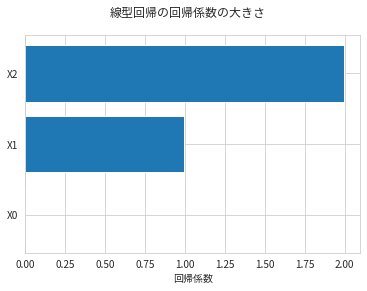

In [5]:
## 線形回帰モデル
from sklearn.linear_model import LinearRegression

def plot_bar(variables, values, title=None, xlabel=None, ylabel=None):
    fig, ax = plt.subplots()
    ax.barh(variables, values)
    ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0,None))
    fig.suptitle(title)
    fig.show()

lm = LinearRegression()
lm.fit(X_train, y_train)
plot_bar(var_names, lm.coef_, "線型回帰の回帰係数の大きさ", "回帰係数")

In [6]:
from sklearn.metrics import mean_squared_error

@dataclass
class PermutationFeatureImportance:
    estimator:Any
    X:np.ndarray
    y:np.ndarray
    var_names:list

    def __post_init__(self) ->None:
        self.baseline = mean_squared_error(
            self.y, self.estimator.predict(self.X), squared=False
        )

    def _permutation_metrics(self, idx_to_permute: int) -> float:
        """

        :param idx_to_permute: シャッフルした特徴量のidx
        :return:
        """
        X_permuted = self.X.copy()

        X_permuted[:, idx_to_permute] = np.random.permutation(
            X_permuted[:, idx_to_permute]
        )
        y_pred = self.estimator.predict(X_permuted)

        return mean_squared_error(self.y, y_pred, squared=False)

    def permutation_feature_importance(self, n_shuffle: int=10) -> 10:
        """

        :param n_shuffle: default =10
        :return:
        """

        J = self.X.shape[1]

        metrics_permuted = [
            np.mean(
                [self._permutation_metrics(j) for r in range(n_shuffle)]
            )
            for j in range(J)
        ]

        # dfとしてまとめる
        # シャッフルでどれくらい精度が落ちるかは差分と比率の2パターンで評価する

        df_feature_importance = pd.DataFrame(
            data={
                "var_name": self.var_names,
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted / self.baseline
            }
        )

        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
        )

    def plot(self, importance_type: str = "difference") -> None:
        """

        :param self:
        :param importance_type: difference, or ratio
        :return:
        """

        fig, ax = plt.subplots()
        ax.barh(
            self.feature_importance["var_name"],
            self.feature_importance[importance_type],
            label=f"baseline: {self.baseline:.2f}"
        )
        ax.set(xlabel=importance_type,ylabel=None)
        ax.invert_yaxis()
        ax.legend()
        fig.suptitle(f"Permutationによる特徴量の重要度({importance_type})")

        fig.show()

In [7]:
## rf での適用
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print(f"R2: {r2_score(y_test, rf.predict(X_test)):.2f}")

R2: 0.99


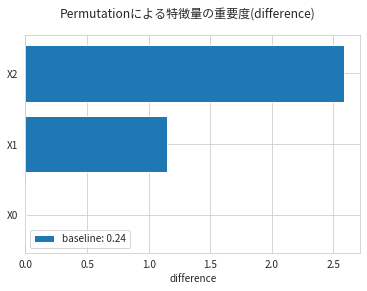

In [8]:
pfi = PermutationFeatureImportance(rf, X_test, y_test, var_names)

pfi.permutation_feature_importance()
pfi.plot(importance_type="difference")

In [31]:
#Grouped Permutation Feature Importance
class GroupedPermutationImportance(PermutationFeatureImportance):
    def _permutation_metrics(self, var_names_to_permute: list) -> float:
        """

        :param var_names_to_permute:
        :return:
        """

        X_permuted = self.X.copy()
        idx_to_permute = [
            self.var_names.index(v) for v in var_names_to_permute
        ]

        X_permuted[:, idx_to_permute] = np.random.permutation(X_permuted[:, idx_to_permute])
        y_pred = self.estimator.predict(X_permuted)

        return mean_squared_error(self.y, y_pred, squared=False)

    def permutation_feature_importance(self, var_groups: list=None, n_shuffle: int=10):
        """

        :param var_groups:
        :param n_shuffle:
        :return:
        """
        if var_groups is None:
            var_groups = [[j] for j in self.var_names]

        # グループごとに重要度を計算
        # R回シャッフルを繰り返して値を安定させる

        metrics_permuted = [
            np.mean(
                [self._permutation_metrics(j) for r in range(n_shuffle)]
            ) for j in var_groups
        ]

        df_feature_importance = pd.DataFrame(
            data={
                "var_name": ["+".join(j) for j in var_groups],
                "baseline": self.baseline,
                "permutation": metrics_permuted,
                "difference": metrics_permuted - self.baseline,
                "ratio": metrics_permuted / self.baseline
            }
        )

        self.feature_importance = df_feature_importance.sort_values(
            "permutation", ascending=False
        )

In [32]:
X_train2 = np.concatenate([X_train, X_train[:, [2]]], axis=1)

In [33]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train2, y_train)

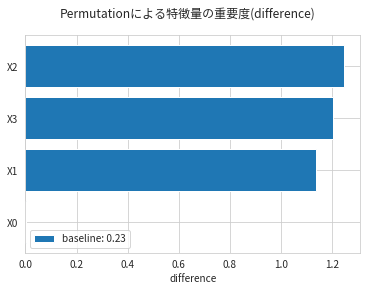

In [34]:
X_test2 = np.concatenate([X_test, X_test[:, [2]]], axis=1)

gpfi = GroupedPermutationImportance(
    rf, X_test2, y_test, ["X0", "X1", "X2", "X3"]
)
gpfi.permutation_feature_importance()

gpfi.plot()

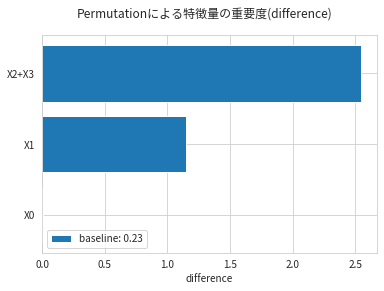

In [35]:
gpfi.permutation_feature_importance(var_groups=[["X0"], ["X1"], ["X2", "X3"]])
gpfi.plot()

## 実データで適用してみる

In [37]:
from sklearn.datasets import load_boston
from sklearn.inspection import permutation_importance

boston = load_boston()

X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

rf.fit(X_train, y_train)


pfi = permutation_importance(
    estimator=rf,
    X=X_test,
    y=y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=5,
    n_jobs=-1,
    random_state=42
)
pfi

{'importances_mean': array([0.47335366, 0.00767681, 0.0488425 , 0.00577725, 0.39998356,
        3.71527662, 0.17887136, 0.94838591, 0.0314633 , 0.11882726,
        0.2915789 , 0.02083006, 3.54059205]),
 'importances_std': array([0.0364208 , 0.00788286, 0.01233191, 0.00195267, 0.04552138,
        0.10845402, 0.03142234, 0.51582081, 0.00712065, 0.03561518,
        0.05189719, 0.03750401, 0.55511839]),
 'importances': array([[ 4.21780470e-01,  4.47578199e-01,  5.24408599e-01,
          4.73160410e-01,  4.99840633e-01],
        [ 3.82160776e-03,  1.44580414e-02,  1.84218654e-02,
          5.36588658e-03, -3.68333178e-03],
        [ 4.75590731e-02,  5.98691482e-02,  6.53492096e-02,
          3.25437839e-02,  3.88913056e-02],
        [ 8.44613611e-03,  3.60372142e-03,  7.20979226e-03,
          3.52744355e-03,  6.09918045e-03],
        [ 3.70942819e-01,  3.32201627e-01,  4.57748542e-01,
          4.39806226e-01,  3.99218573e-01],
        [ 3.71381796e+00,  3.83244494e+00,  3.53957912e+00,
  

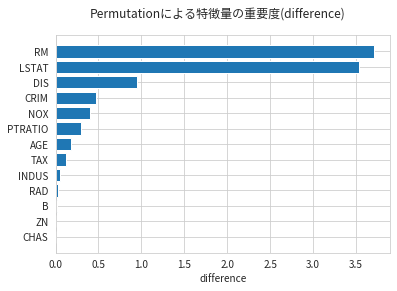

In [44]:
# dfにする
df_pfi = pd.DataFrame(data={
    "var_name":X_test.columns,
    "importance_mean": pfi["importances_mean"],
    "importance_std": pfi["importances_std"]
}).sort_values("importance_mean")

plot_bar(df_pfi["var_name"],df_pfi["importance_mean"], xlabel="difference", title="Permutationによる特徴量の重要度(difference)")